# Numerical implementation of Dirac
SageMath script.  (But probably could be just plain Python with some minor adjustment).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [1]:
## Pauli and Gamma matrices

In [6]:
one = matrix([[1,0],[0,1]])
zero = matrix([[0,0], [0,0]])
p1 = matrix([[0,1],[1,0]])
p2 = matrix([[0,-1j],[1j,0]])
p3 = matrix([[1,0],[0,-1]])

In [7]:
def pauli(i):
    d = {1: p1, 2: p2, 3: p3}
    return d[i]
show(pauli(1), pauli(2) ,pauli(3))

[0 1]
[1 0] [  0.000000000000000 -1.00000000000000*I]
[ 1.00000000000000*I   0.000000000000000] [ 1  0]
[ 0 -1]

In [8]:
def compose(a,b,c,d):
    # a b
    # c d
    return matrix(
        np.vstack([
            np.hstack([a,b]),
            np.hstack([c,d])
    ]))
show(compose(one, p1, p2, p3))

[   1.0    0.0    0.0    1.0]
[   0.0    1.0    1.0    0.0]
[   0.0 -1.0*I    1.0    0.0]
[ 1.0*I    0.0    0.0   -1.0]

In [9]:
def gamma(i):
    # The four gamma matrices
    if i == 0:
        return compose(one, zero, zero, -one)
    else:
        return compose(zero, pauli(i), -pauli(i), zero)
show(gamma(0), gamma(1), gamma(2), gamma(3))

[ 1  0  0  0]
[ 0  1  0  0]
[ 0  0 -1  0]
[ 0  0  0 -1] [ 0  0  0  1]
[ 0  0  1  0]
[ 0 -1  0  0]
[-1  0  0  0] [   0.0    0.0    0.0 -1.0*I]
[   0.0    0.0  1.0*I    0.0]
[   0.0  1.0*I    0.0    0.0]
[-1.0*I    0.0    0.0    0.0] [ 0  0  1  0]
[ 0  0  0 -1]
[-1  0  0  0]
[ 0  1  0  0]

In [10]:
def normalise(phi4):
    a = np.sum(phi4 * np.conjugate(phi4))
    return phi4 / sqrt(a)

def test_normalise():
    phi = np.zeros((6,6,6,4), np.cdouble)
    phi[3,3,3,0] = 1 + 1.j
    print(phi[3,3,3,0])
    phi_n = normalise(phi)
    print(phi_n[3,3,3,0])
    phi_nn = normalise(phi_n)
    print(phi_nn[3,3,3,0])
    
test_normalise()
    

(1+1j)
(0.7071067811865475+0.7071067811865475j)
(0.7071067811865476+0.7071067811865476j)


## Define Phi(t+1) as a function of Phi(t)

$i \hbar \gamma^\mu \partial_\mu \Psi - m \Psi = 0$

So rearanging for $\partial\Psi_t$

$\partial\Psi_t = -\frac{i}{\hbar}(\gamma^0 m + \gamma^k \partial_k) \Psi$, $k=1,2,3$

$\partial\Psi_t = -\frac{i}{\hbar}(m \gamma^0 \Psi + \gamma^k \partial_k \Psi)$


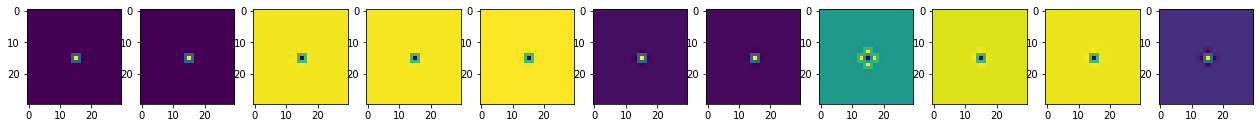

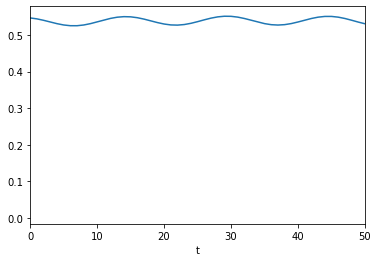

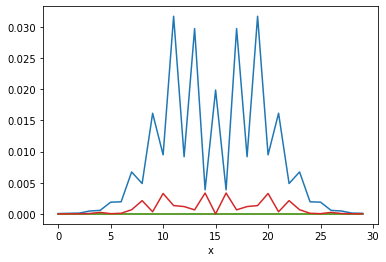

In [11]:
def advance(phi4, m, dt):
    # phy4 is a field defined over x,y,z, with as 4-spinor at each point
    # phy4[x,y,z,s]  where s in 0..3
    assert phi4.ndim == 4
    # x,y,z gradients by shift (roll) and subtract
    dx = (np.roll(phi4, 1, 0) - np.roll(phi4, -1, 0)) / 2
    dy = (np.roll(phi4, 1, 1) - np.roll(phi4, -1, 1)) / 2
    dz = (np.roll(phi4, 1, 2) - np.roll(phi4, -1, 2)) / 2
    
    ddt = -1.j * (
        np.einsum('is,xyzs->xyzi', gamma(0), phi4) * m + 
            np.einsum('is,xyzs->xyzi', gamma(1), dx) + 
            np.einsum('is,xyzs->xyzi', gamma(2), dy) + 
            np.einsum('is,xyzs->xyzi', gamma(3), dz))
    
    return phi4 + ddt * dt
    
def test_advance():
    s=30
    hs=s//2
    phi0 = np.zeros((s,s,s,4), np.cdouble)
    
    phi0[hs-1:hs+2,hs-1:hs+2,hs-1:hs+2, 0] = 0.3
    phi0[hs,hs,hs,0] = 1
    phi0 = normalise(phi0)
    
    m = 4
    nsteps = 12
    
    plt.figure(figsize=(2*nsteps,2))
    phi = phi0
    for step in range(1, nsteps):
        plt.subplot(1, nsteps, step)
        plt.imshow(real_part(phi[:,:,hs,0]))
        phi = normalise(advance(phi, m, .5))
    plt.show()
    
    
    phi = phi0
    p=[]
    tstep = 0.05
    nsteps = 1000
    for step in range(0, nsteps):
        phi = normalise(advance(phi, m, tstep))
        p += [abs(phi[hs,hs,hs,0])]
    plt.plot(p)
    plt.xlabel('t')
    plt.xlim(0, tstep*nsteps)
    plt.show()
    
    plt.figure()
    plt.plot(abs(phi[:,hs,hs,0]))
    plt.plot(abs(phi[:,hs,hs,1]))
    plt.plot(abs(phi[:,hs,hs,2]))
    plt.plot(abs(phi[:,hs,hs,3]))
    plt.xlabel('x')
    plt.show()
   
test_advance()
    